In [1]:
using Random
Random.seed!(4649373)

using Distributions
using StatsPlots
default(fmt=:png, titlefontsize=10, size=(400, 250))

ECDF(A, x) = count(≤(x), A) / length(A)

ECDF (generic function with 1 method)

se = √(var(distx) / m + var(disty) / n) = 0.570087712549569
se_shuffle = √(var(disty) / m + var(distx) / n) = 0.31622776601683794
  7.984185 seconds (156.60 M allocations: 4.149 GiB, 7.19% gc time, 55.51% compilation time)
mean(diff) = 0.00012468485988032584
std(diff) = 0.57420658178132
ECDF.((pval, pval2, pval3), 0.1) = (0.35975, 0.35925, 0.10225)
ECDF.((pval, pval2, pval3), 0.05) = (0.28075, 0.284, 0.0515)


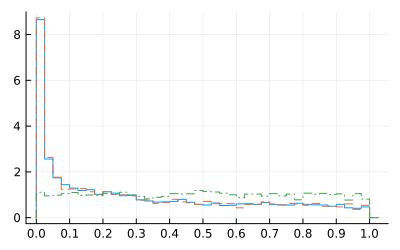

In [3]:
distx = Normal(0, 1)
m = 200
disty = Normal(0, 4)
n = 50
L = 4000
Nshuffles = 4000

@show se = √(var(distx)/m + var(disty)/n)
@show se_shuffle = √(var(disty)/m + var(distx)/n)

nth = Threads.nthreads()
XYtmp = [zeros(m+n) for _ in 1:nth]

pval = zeros(L)
pval2 = zeros(L)
pval3 = zeros(L)
diff = zeros(L)
@time Threads.@threads for i in eachindex(pval)
    tid = Threads.threadid()
    XY = XYtmp[tid]
    X = rand!(distx, @view XY[1:m])
    Y = rand!(disty, @view XY[m+1:m+n])
    diff[i] = mean(X) - mean(Y)
    diff_shuffle = zeros(Nshuffles)
    for j in 1:Nshuffles
        shuffle!(XY)
        diff_shuffle[j] = @views mean(XY[1:m]) - mean(XY[m+1:m+n])
    end
    P = 2ECDF(diff_shuffle, diff[i])
    pval[i] = min(1, P, 2-P)
    P2 = 2cdf(Normal(0, se_shuffle), diff[i])
    pval2[i] = min(1, P2, 2-P2)
    P3 = 2cdf(Normal(0, se), diff[i])
    pval3[i] = min(1, P3, 2-P3)
end

@show mean(diff) std(diff)

@show ECDF.((pval, pval2, pval3), 0.10)
@show ECDF.((pval, pval2, pval3), 0.05)
plot()
stephist!(pval; norm=true, label="", bin=0:0.025:1.025)
stephist!(pval2; norm=true, label="", bin=0:0.025:1.025, ls=:dash)
stephist!(pval3; norm=true, label="", bin=0:0.025:1.025, ls=:dashdot)
plot!(xtick=0:0.1:1)

diff = mean(X) - mean(Y) = 0.26057773015026786
se2_true = var(distx) / m + var(disty) / n = 0.325
se2_shuffle = var(distx) / n + var(disty) / m = 0.1
(mean(diff_shuffle), var(diff_shuffle)) = (-0.0022537261910985126, 0.10751259501204201)


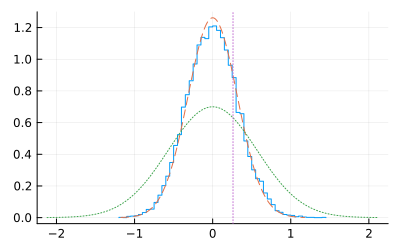

In [4]:
distx, m = Normal(0, 1), 200
disty, n = Normal(0, 4), 50
X = rand(distx, m)
Y = rand(disty, n)
@show diff = mean(X) - mean(Y)
XY = [X; Y]
Nshuffles = 10^4
diff_shuffle = zeros(Nshuffles)
for j in 1:Nshuffles
    shuffle!(XY)
    diff_shuffle[j] = @views mean(XY[1:m]) - mean(XY[m+1:m+n])
end
@show se2_true = var(distx)/m + var(disty)/n
@show se2_shuffle = var(distx)/n + var(disty)/m
@show mean(diff_shuffle), var(diff_shuffle)
stephist(diff_shuffle; norm=true, label="")
plot!(Normal(0, √se2_shuffle); label="", ls=:dash)
plot!(Normal(0, √se2_true); label="", ls=:dot)
vline!([diff]; label="", ls=:dot)

In [2]:
function welch_t_test(X, Y; μ = 0.0)
    m, X̄, SX2 = length(X), mean(X), var(X)
    n, Ȳ, SY2 = length(Y), mean(Y), var(Y)
    sehat2 = SX2/m + SY2/n
    tvalue = (X̄ - Ȳ - μ) / √sehat2
    df = sehat2^2 / ((SX2/m)^2/(m-1) + (SY2/n)^2/(n-1))
    pvalue = 2ccdf(TDist(df), abs(tvalue))
    (; pvalue, tvalue, sehat2, df)
end

pvalue_welch_t_test(X, Y; μ = 0.0) =welch_t_test(X, Y; μ).pvalue

using HypothesisTests
X = randn(100)
Y = randn(100)
pvalue_welch_t_test(X, Y), pvalue(UnequalVarianceTTest(X, Y))

(0.4441279969334514, 0.4441279969334514)

In [12]:
"""
inversegammadist(σ, β)

returns the inverse gamma distribution with standard deviation `σ` and skewness `β`.
"""
function inversegammadist(σ, β)
    β == 0 && return Normal(0, σ)
    α = 3 + 8/β^2 + 4/β * √(1 + 4/β^2)
    θ = σ * (α - 1) * √(α - 2)
    InverseGamma(α, θ)
end

igam = inversegammadist.(1:5, 2:2:10)
[std.(igam), skewness.(igam), kurtosis.(igam), shape.(igam)]

4-element Vector{Vector{Float64}}:
 [0.9999999999999999, 2.0, 3.0, 3.9999999999999996, 5.0]
 [2.0, 4.0, 6.0, 7.999999999999998, 10.0]
 [9.134446499564898, 72.54101966249682, NaN, NaN, NaN]
 [7.82842712474619, 4.618033988749895, 3.9249505911485287, 3.6403882032022077, 3.487921561087423]

In [5]:
function plot_sim_diff_shuffle(;
        distx = Normal(0, 1), m = 200,
        disty = Normal(0, 4), n = 50,
        difffunc1 = (X, Y) -> mean(X) - mean(Y),
        difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
        L = 4000,
        Nshuffles = 4000,
    )

    @show distx disty m n
    @show se_true = √(var(distx)/m + var(disty)/n)
    @show se_shuffle = √(var(distx)/n + var(disty)/m)

    nth = Threads.nthreads()
    XYtmp = [zeros(m+n) for _ in 1:nth]
    diffshuffle1tmp = [zeros(Nshuffles) for _ in 1:nth]
    diffshuffle2tmp = [zeros(Nshuffles) for _ in 1:nth]

    pval1 = zeros(L)
    pval2 = zeros(L)
    pvalw = zeros(L)
    diff1 = zeros(L)
    diff2 = zeros(L)
    @time Threads.@threads for i in 1:L
        tid = Threads.threadid()
        XY = XYtmp[tid]
        diffshuffle1 = diffshuffle1tmp[tid]
        diffshuffle2 = diffshuffle2tmp[tid]
        X = rand!(distx, @view XY[1:m])
        Y = rand!(disty, @view XY[m+1:m+n])
        diff1[i] = difffunc1(X, Y)
        diff2[i] = difffunc2(X, Y)
        pvalw[i] = pvalue_welch_t_test(X, Y)
        for j in 1:Nshuffles
            shuffle!(XY)
            @views X, Y = XY[1:m], XY[m+1:m+n]
            diffshuffle1[j] = difffunc1(X, Y)
            diffshuffle2[j] = difffunc2(X, Y)
        end
        P1 = 2ECDF(diffshuffle1, diff1[i])
        pval1[i] = min(1, P1, 2-P1)
        P2 = 2ECDF(diffshuffle2, diff2[i])
        pval2[i] = min(1, P2, 2-P2)
    end

    @show mean(diff1) std(diff1)
    @show mean(diff2) std(diff2)

    @show ECDF.((pval1, pval2, pvalw), 0.10)
    @show ECDF.((pval1, pval2, pvalw), 0.05)
    plot()
    stephist!(pval1; norm=true, label="1", bin=0:0.025:1.025)
    stephist!(pval2; norm=true, label="2", bin=0:0.025:1.025, ls=:dash)
    stephist!(pvalw; norm=true, label="Welch", bin=0:0.025:1.025, ls=:dashdot)
    plot!(xtick=0:0.1:1)
end

plot_sim_diff_shuffle (generic function with 1 method)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
m = 100
n = 50
se_true = √(var(distx) / m + var(disty) / n) = 0.3
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.2449489742783178
 26.388116 seconds (198.24 k allocations: 14.675 MiB, 7.37% compilation time)
mean(diff1) = 0.002597722882128812
std(diff1) = 0.3004406371229854
mean(diff2) = 0.009776545586482877
std(diff2) = 1.019025087843896
ECDF.((pval1, pval2, pvalw), 0.1) = (0.1783, 0.1074, 0.1019)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.1109, 0.0576, 0.0516)


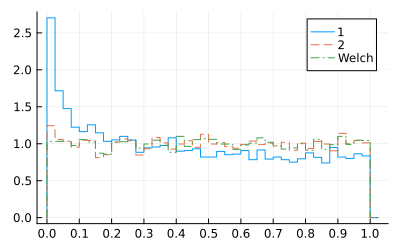

In [6]:
plot_sim_diff_shuffle(;
    distx = Normal(0, 1), m = 100,
    disty = Normal(0, 2), n = 50,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
m = 50
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.2449489742783178
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.3
 26.717508 seconds (142.14 k allocations: 10.929 MiB, 4.71% compilation time)
mean(diff1) = 0.0009686952585552308
std(diff1) = 0.2450769072237884
mean(diff2) = 0.005328849784174428
std(diff2) = 1.0089255239426866
ECDF.((pval1, pval2, pvalw), 0.1) = (0.0444, 0.0958, 0.0977)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0175, 0.0465, 0.0487)


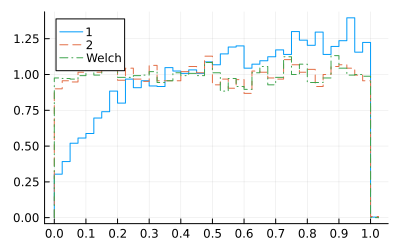

In [7]:
plot_sim_diff_shuffle(;
    distx = Normal(0, 1), m = 50,
    disty = Normal(0, 2), n = 100,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=2.0)
m = 75
n = 75
se_true = √(var(distx) / m + var(disty) / n) = 0.2581988897471611
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.2581988897471611
 27.673185 seconds (142.17 k allocations: 10.934 MiB, 4.55% compilation time)
mean(diff1) = 0.0029888116372938354
std(diff1) = 0.2592661164483405
mean(diff2) = 0.011815059296349614
std(diff2) = 1.0121205004987184
ECDF.((pval1, pval2, pvalw), 0.1) = (0.0982, 0.0982, 0.0979)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0506, 0.0506, 0.05)


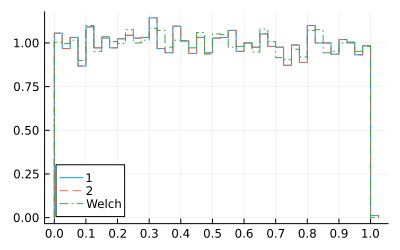

In [8]:
plot_sim_diff_shuffle(;
    distx = Normal(0, 1), m = 75,
    disty = Normal(0, 2), n = 75,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=4.0)
m = 100
n = 50
se_true = √(var(distx) / m + var(disty) / n) = 0.5744562646538028
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.4242640687119285
 26.637451 seconds (142.08 k allocations: 10.912 MiB, 4.52% compilation time)
mean(diff1) = 0.001368823036676498
std(diff1) = 0.5741674969198991
mean(diff2) = 0.002858694040830176
std(diff2) = 1.0198589594596887
ECDF.((pval1, pval2, pvalw), 0.1) = (0.2294, 0.1165, 0.1029)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.1536, 0.0633, 0.0505)


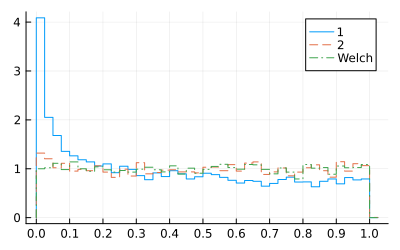

In [9]:
plot_sim_diff_shuffle(;
    distx = Normal(0, 1), m = 100,
    disty = Normal(0, 4), n = 50,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=4.0)
m = 50
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.4242640687119285
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.5744562646538028
 26.749581 seconds (142.10 k allocations: 10.915 MiB, 5.12% compilation time)
mean(diff1) = 0.000698811070516511
std(diff1) = 0.42576483201659554
mean(diff2) = 0.001883485407744007
std(diff2) = 1.0119032544533386
ECDF.((pval1, pval2, pvalw), 0.1) = (0.029, 0.0939, 0.097)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0088, 0.0467, 0.0492)


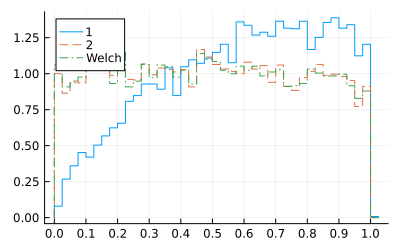

In [10]:
plot_sim_diff_shuffle(;
    distx = Normal(0, 1), m = 50,
    disty = Normal(0, 4), n = 100,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = Normal{Float64}(μ=0.0, σ=1.0)
disty = Normal{Float64}(μ=0.0, σ=4.0)
m = 75
n = 75
se_true = √(var(distx) / m + var(disty) / n) = 0.47609522856952335
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.47609522856952335
 27.132806 seconds (142.29 k allocations: 10.974 MiB, 4.49% compilation time)
mean(diff1) = -0.0035033512820687677
std(diff1) = 0.48537731813520846
mean(diff2) = -0.008265812049349203
std(diff2) = 1.0314733924027761
ECDF.((pval1, pval2, pvalw), 0.1) = (0.107, 0.107, 0.1055)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0556, 0.0556, 0.0535)


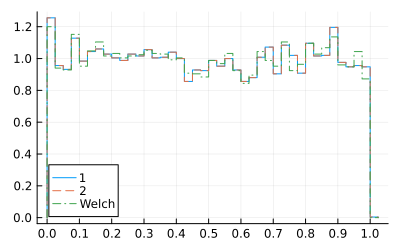

In [11]:
plot_sim_diff_shuffle(;
    distx = Normal(0, 1), m = 75,
    disty = Normal(0, 4), n = 75,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 25
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.22360679774997896
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.22360679774997896
 21.616688 seconds (254.37 k allocations: 18.422 MiB, 9.76% compilation time)
mean(diff1) = -0.0019983023811665623
std(diff1) = 0.2244251396355922
mean(diff2) = -0.1530224272366159
std(diff2) = 1.0648695518449316
ECDF.((pval1, pval2, pvalw), 0.1) = (0.1011, 0.1015, 0.115)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0488, 0.0505, 0.0644)


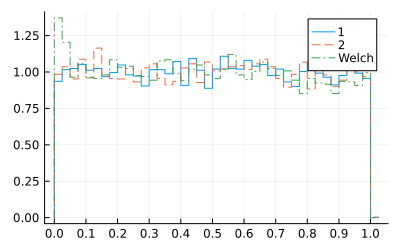

In [13]:
distx = inversegammadist(1, 3)
disty = inversegammadist(1, 3)
m = 25
n = 100

plot_sim_diff_shuffle(;
    distx, m,
    disty, n,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = InverseGamma{Float64}(
invd: Gamma{Float64}(α=3.487921561087423, θ=0.32951356487309685)
θ: 3.034776429872083
)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=3.487921561087423, θ=0.32951356487309685)
θ: 3.034776429872083
)

m = 25
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.22360679774997896
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.22360679774997896
 23.037872 seconds (169.41 k allocations: 12.924 MiB, 6.22% compilation time)
mean(diff1) = -0.0037109122908523615
std(diff1) = 0.22634824783048874
mean(diff2) = -0.22517565455787217
std(diff2) = 1.0956011314123433
ECDF.((pval1, pval2, pvalw), 0.1) = (0.1062, 0.1056, 0.1263)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0508, 0.0528, 0.0725)


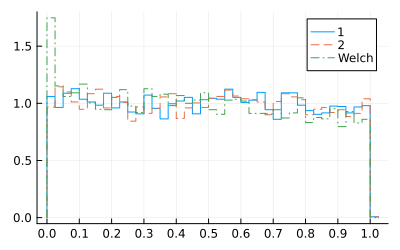

In [20]:
distx = inversegammadist(1, 10)
disty = inversegammadist(1, 10)
m = 25
n = 100

plot_sim_diff_shuffle(;
    distx, m,
    disty, n,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: 0.5456964705517653
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=7.82842712474619, θ=0.0606601717798213)
θ: 16.485281374238568
)

m = 25
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.22360679774997896
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.22360679774997896
 22.507584 seconds (161.02 k allocations: 12.222 MiB, 0.05% gc time, 7.24% compilation time)
mean(diff1) = -0.0014933720285137666
std(diff1) = 0.223440442688858
mean(diff2) = -0.156940963063453
std(diff2) = 1.0715538747576148
ECDF.((pval1, pval2, pvalw), 0.1) = (0.0978, 0.1031, 0.114)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0459, 0.0516, 0.0645)


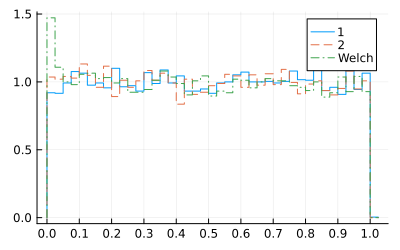

In [14]:
distx = inversegammadist(1, 3)
disty = inversegammadist(1, 2)
distx = distx + mean(disty) - mean(distx)
m = 25
n = 100

plot_sim_diff_shuffle(;
    distx, m,
    disty, n,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

)

disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.22360679774997896
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.22360679774997896
 22.313699 seconds (143.10 k allocations: 11.063 MiB, 5.30% compilation time)
mean(diff1) = 0.0011900800789204492
std(diff1) = 0.22442884601953667
mean(diff2) = -0.15558266751330074
std(diff2) = 1.0767598658700888
ECDF.((pval1, pval2, pvalw), 0.1) = (0.0914, 0.1142, 0.1127)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0381, 0.0619, 0.0644)


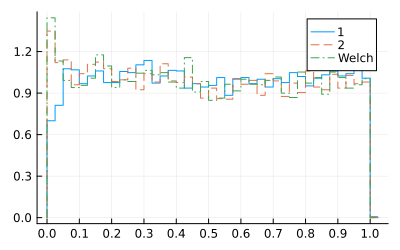

In [18]:
distx = inversegammadist(1, 3)
disty = inversegammadist(1, 0)
distx = distx + mean(disty) - mean(distx)
m = 25
n = 100

plot_sim_diff_shuffle(;
    distx, m,
    disty, n,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.219803902718557
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=3.487921561087423, θ=0.32951356487309685)
θ: 3.034776429872083
)

)

disty = Normal{Float64}(μ=0.0, σ=1.0)
m = 25
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.22360679774997896
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.22360679774997896
 23.264717 seconds (143.32 k allocations: 11.104 MiB, 5.58% compilation time)
mean(diff1) = -0.0026252013048952824
std(diff1) = 0.2197286164777362
mean(diff2) = -0.23904495513860943
std(diff2) = 1.0914551869070035
ECDF.((pval1, pval2, pvalw), 0.1) = (0.0666, 0.1235, 0.1228)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.0291, 0.0731, 0.0755)


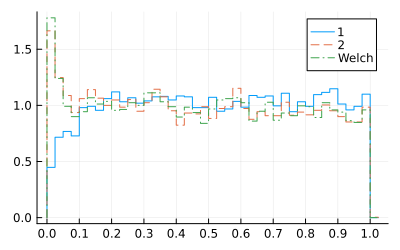

In [19]:
distx = inversegammadist(1, 10)
disty = inversegammadist(1, 0)
distx = distx + mean(disty) - mean(distx)
m = 25
n = 100

plot_sim_diff_shuffle(;
    distx, m,
    disty, n,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 25
n = 100
se_true = √(var(distx) / m + var(disty) / n) = 0.41231056256176607
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.282842712474619
 22.501623 seconds (154.26 k allocations: 11.783 MiB, 6.06% compilation time)
mean(diff1) = -0.0021475908252903833
std(diff1) = 0.4112482905579518
mean(diff2) = -0.2209385711566888
std(diff2) = 1.1395696583918442
ECDF.((pval1, pval2, pvalw), 0.1) = (0.2598, 0.1295, 0.1259)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.1801, 0.0772, 0.0764)


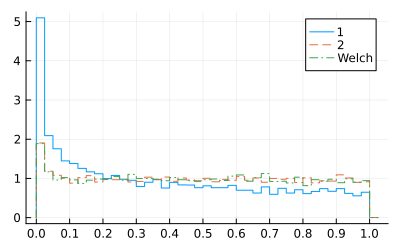

In [16]:
distx = inversegammadist(2, 3)
disty = inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m = 25
n = 100

plot_sim_diff_shuffle(;
    distx, m,
    disty, n,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)

distx = LocationScale{Float64, Continuous, InverseGamma{Float64}}(
μ: -1.8685170918213296
σ: 1.0
ρ: InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.0595793056595373)
θ: 16.784351360427824
)

)

disty = InverseGamma{Float64}(
invd: Gamma{Float64}(α=5.4913561224284395, θ=0.1191586113190746)
θ: 8.392175680213912
)

m = 5
n = 20
se_true = √(var(distx) / m + var(disty) / n) = 0.9219544457292888
se_shuffle = √(var(distx) / n + var(disty) / m) = 0.6324555320336759
  6.485601 seconds (153.84 k allocations: 11.661 MiB, 25.77% compilation time)
mean(diff1) = 0.006829220143159196
std(diff1) = 0.9369629873310755
mean(diff2) = -0.41590175683930247
std(diff2) = 1.430564065360493
ECDF.((pval1, pval2, pvalw), 0.1) = (0.2669, 0.1795, 0.1529)
ECDF.((pval1, pval2, pvalw), 0.05) = (0.1893, 0.121, 0.0999)


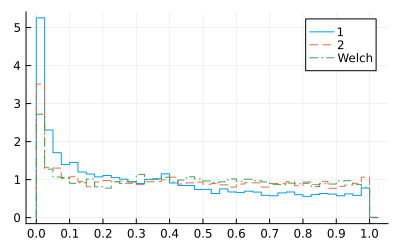

In [21]:
distx = inversegammadist(2, 3)
disty = inversegammadist(1, 3)
distx = distx + mean(disty) - mean(distx)
m = 5
n = 20

plot_sim_diff_shuffle(;
    distx, m,
    disty, n,
    difffunc1 = (X, Y) -> mean(X) - mean(Y),
    difffunc2 = (X, Y) -> (mean(X) - mean(Y)) / √(var(X)/length(X) + var(Y)/length(Y)),
    L = 10000,
    Nshuffles = 10000,
)